In [17]:
# Just open the terminal and paste:
# voila /Users/user/Desktop/COVID_19_analysis/COVID-19_England_dashboard_6-May_FINAL.ipynb --template=material


# Markdown cells intructions
# https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

# This one is even better
# https://medium.com/game-of-data/12-things-to-know-about-jupyter-notebook-markdown-3f6cef811707

# **COVID-19 NHS England report dashboard**




#### Last updated on 06-05-2020

This dashboard contains information on deaths of patients in England who had tested positive for COVID-19 at time of death, or where COVID-19 was mentioned on the death certificate.

Interpretation of the figures should take into account the fact that totals by date of death are likely to be updated in future releases for more recent dates.

**These figures do not include deaths outside hospital.**





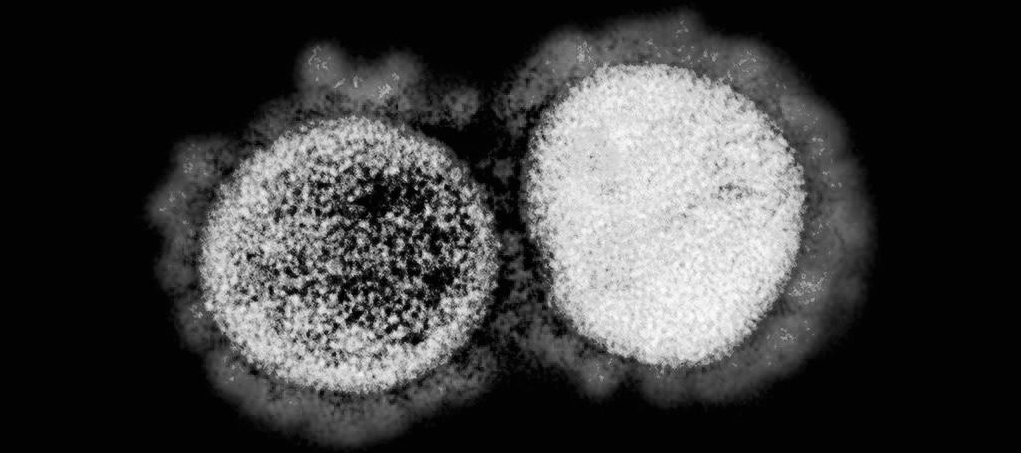

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
%matplotlib inline

import plotly.io as pio   # To set up themes (backgrounds) in Plotly. I like the simple_white 
pio.templates.default = "plotly_white"  # For more, look in: https://plotly.com/python/templates/

In [19]:
# We get the excel with the data (COVID-19 ALL ANNOUNCED DEATHS) from: https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/
# The get it directly from pandas, we do a bit of web scrapping using "view source" in chrome. By doing that, we can see how our excel is: https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-total-announced-deaths-01-May-2020.xlsx
# The excel has several tabs; we want just the one with the deaths per hospital: tab "COVID19 total deaths by trust" 

df = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total deaths by trust")

df_region = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total deaths by region")

df_region2 = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total deaths by region")

df_gender = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total by gender")

df_gender2 = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total by gender")

df_condition = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total by condition")

df_condition2 = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-6-May-2020.xlsx", sheet_name="COVID19 total by condition")



# <span style='color:White'> SPACE  </span>



## COVID-19 total deaths by England NHS Trust


In [20]:
# We remove the rows that we are not interested
df.drop(df.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16]], inplace=True)

# And now we drop all columns with NaN
df.dropna(axis=1, how='any', inplace= True)

# Now we reset the index, so it doesn´t start from 14
df = df.reset_index(drop=True)

# In previous versions, I had (lat,long) and I splitted it with a function, but it was
# giving me problems

# First, I need to read the csv
df2 = pd.read_csv("Coordinates_splitted_Lat_Long.csv")

# And now we add those 2 new columns to df
df["Lat"] = df2["Lat"]
df["Long"] = df2["Long"]

# Now we re-order the columns, so we have lat and long close to the name
mid = df['Lat']
df.drop(labels=['Lat'], axis=1, inplace = True)
df.insert(2, 'Lat', mid)

# Now we re-order the columns, so we have lat and long close to the name
mid = df['Long']
df.drop(labels=['Long'], axis=1, inplace = True)
df.insert(3, 'Long', mid)

# And now we change the name of the columns for the 1st row
df.columns = df.iloc[0]

# Now we drop the 1st row (as now it is the name of the columns)
df = df.drop(df.index[0])

# And now we reset the index, so it starts from 0
df = df.reset_index(drop=True)

import folium
from folium import plugins

# First, we create the figure (f) with the map 

f = folium.Figure(width=1000, height=1000)
UK_map = folium.Map(location = [53.091972, -1.883919], tiles="cartodbpositron", zoom_start=7, min_zoom = 6).add_to(f)




# Now, we indicate what data we want to plot  
for i in range(len(df)):  # It goes throug all the rows of df,
    folium.Circle(        # and plots circles
    location=[df.iloc[i]["Lat"], df.iloc[i]["Long"]],  # with a location specified in the cloums Lat and Long of very row
    fill = True,    # The circles are going to be color filled
    radius = (int((np.log(df.iloc[i,-1]+1.00001))) + 0.2)*3000,  # The radius of every circle is  the int of (the log of the last column of df (df.iloc[i,-1] --> Total), adding 1 just in case is 0 (log 0 gives error)) plus 0.2 and 3000 times --> By doing that, the size of the bubbles is OK
    fill_color = "red",  # The filling colour is red 
    color = "red",   # The colour of te circle line is red (but it is very thin, so almost no visible)
    weight=0.9,  # The weight of the line --> Very thing
    opacity=0.2,  # The opacity of the line   
    tooltip = "<div style='margin: 0; background-color: white; color: blue;'>"+
                    "<h4 style='text-align:center;font-size:12px'>"+df.iloc[i]['Name'] + "</h4>"
                    "<hr style='margin:10px;color: black;'>"+
                    "<ul style='color: black;;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                        "<li>Deaths up to date: "+str(df.iloc[i,-1])+"</li>"+
                    "</ul></div>",
        
        
    ).add_to(UK_map)
    
f

# <span style='color:White'> SPACE  </span>

## NHS regions
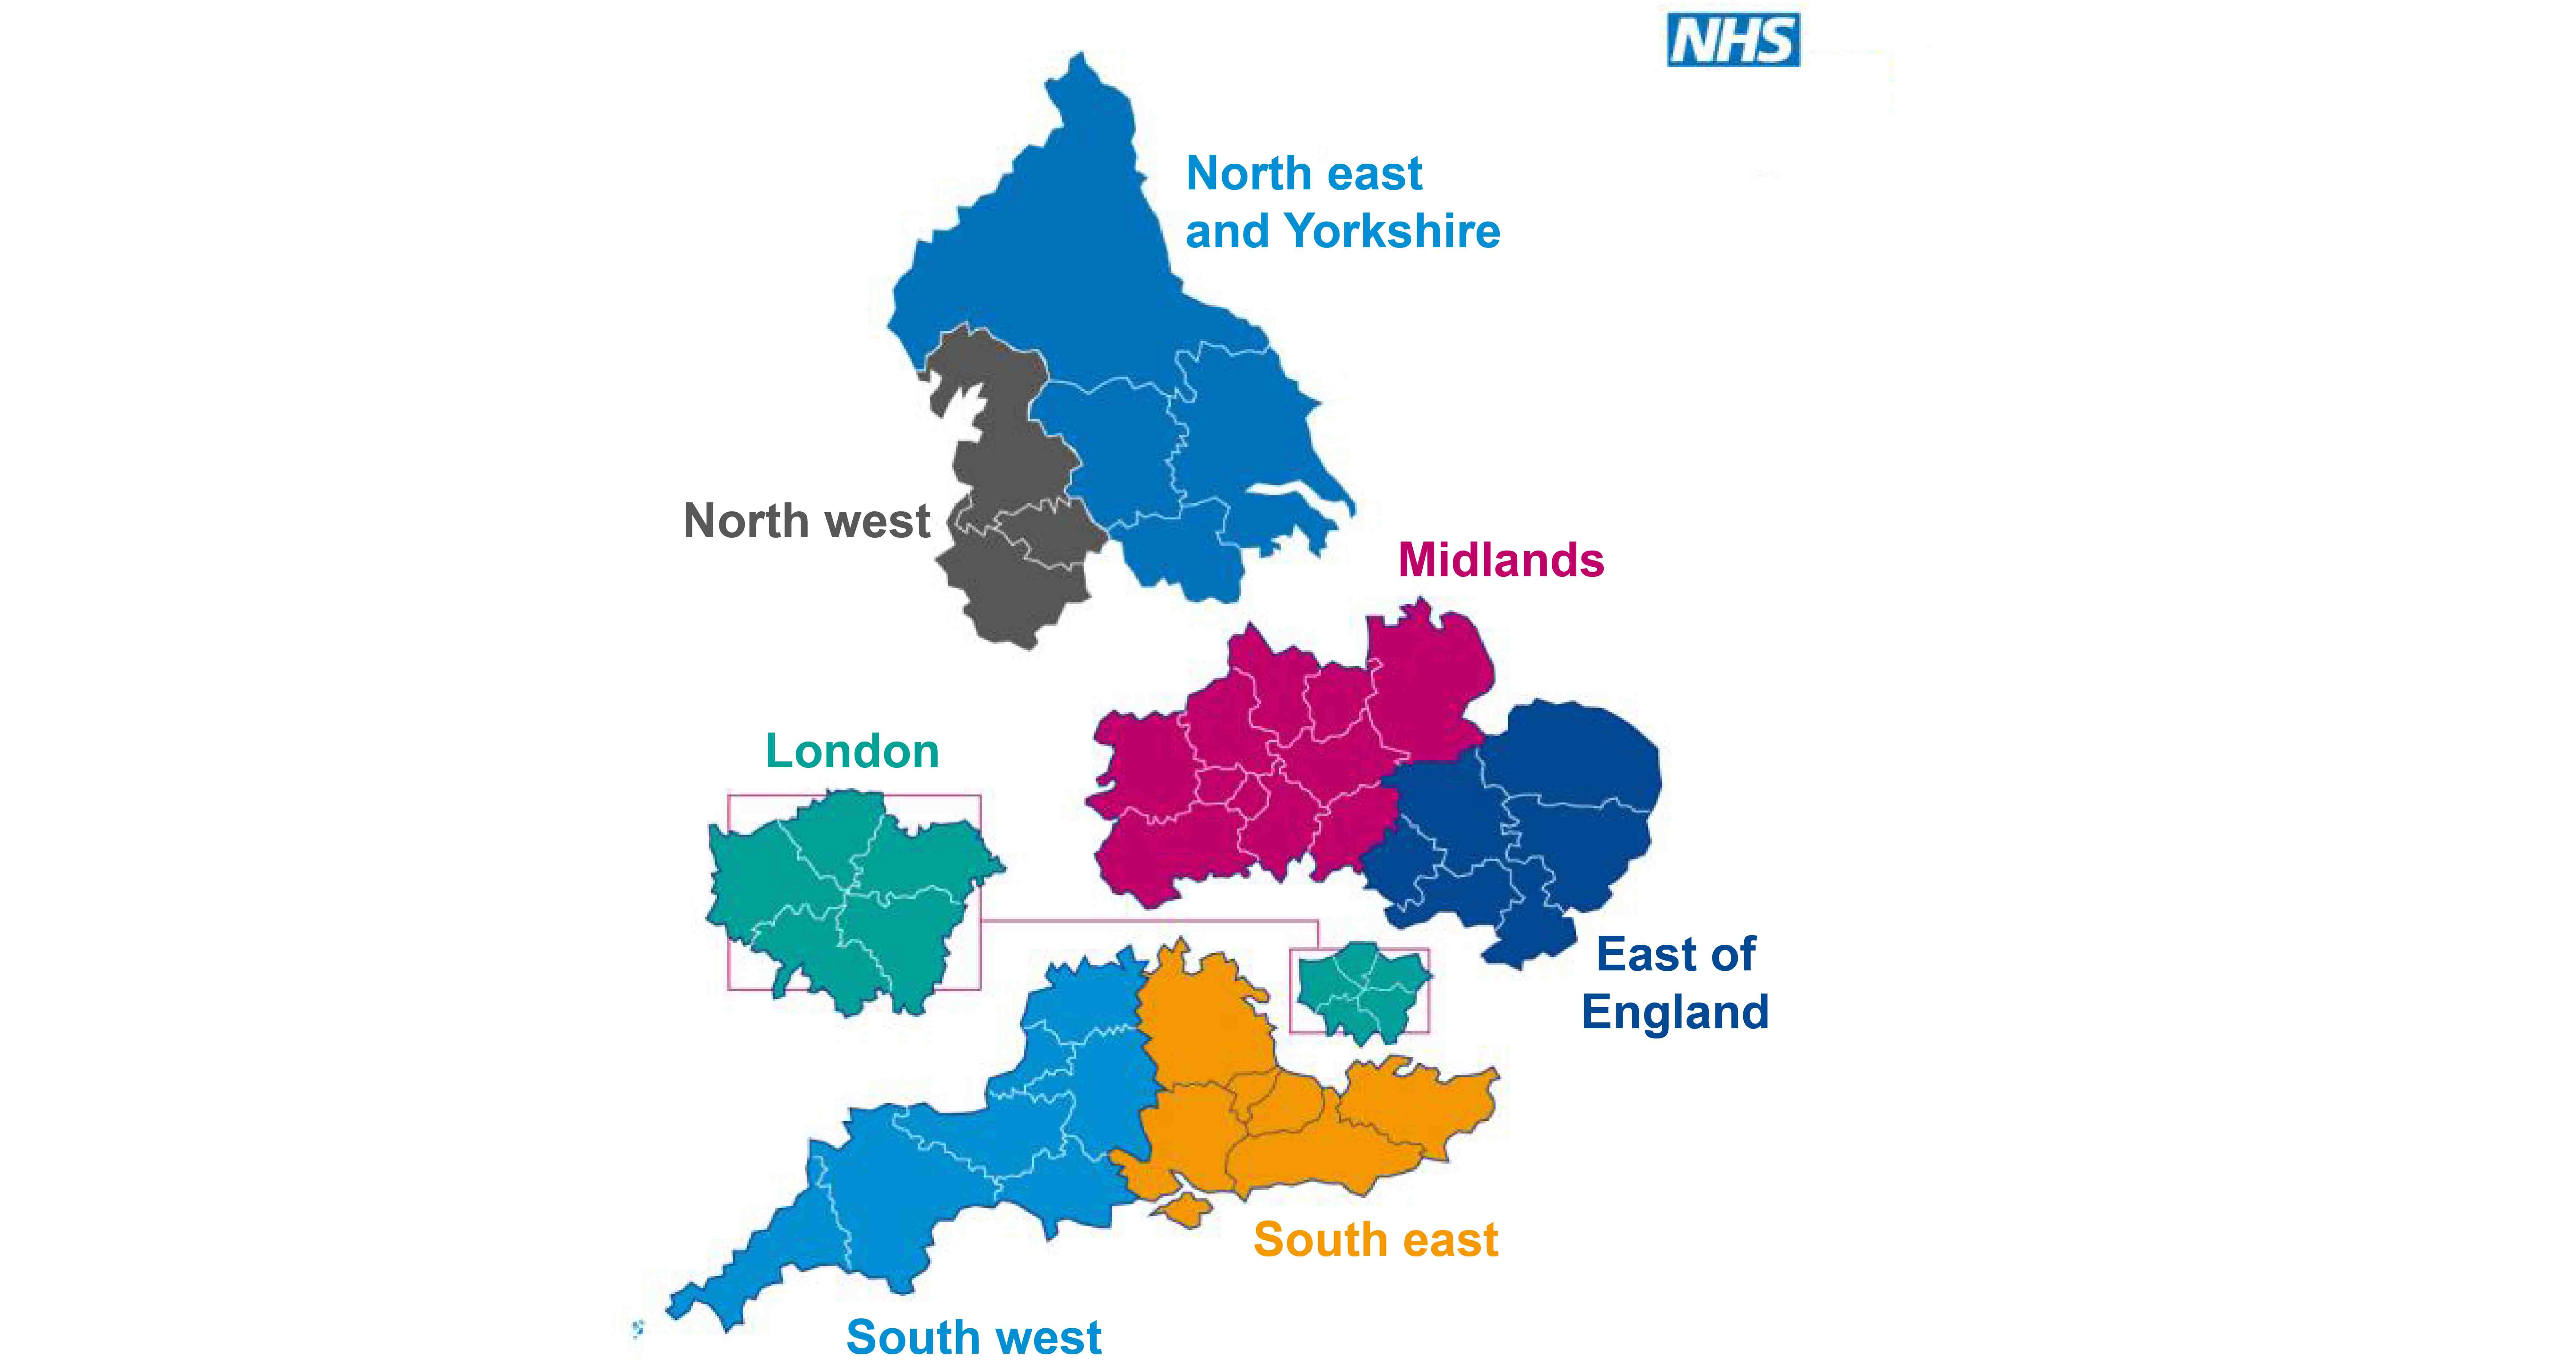


## COVID-19 total deaths by NHS region

In [21]:
# That is done! Now let´s work on the NHS regions map; it should be easier that this one.
# Now we use df_region taht we loaded in the 1st cell

############################### For folium map
df_region

# We remove the rows that we are not interested
df_region.drop(df_region.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16]], inplace=True)

# And now we drop all columns with NaN
df_region.dropna(axis=1, how='any', inplace= True)

# Now we reset the index, so it doesn´t start from 14
df_region = df_region.reset_index(drop=True)

# Now we read the csv with the coordinates of each region
df3 = pd.read_csv("Coordinates_region.csv")

# And now we add those 2 new columns from df3 to df_region
df_region["Lat"] = df3["Lat"]
df_region["Long"] = df3["Long"]

# Now we re-order the column Lat, so we have lat and long close to the name
mid = df_region['Lat']
df_region.drop(labels=['Lat'], axis=1, inplace = True)
df_region.insert(2, 'Lat', mid)

# Now we re-order the column Long, so we have lat and long close to the name
mid = df_region['Long']
df_region.drop(labels=['Long'], axis=1, inplace = True)
df_region.insert(3, 'Long', mid)

# And now we change the name of the columns for the 1st row
df_region.columns = df_region.iloc[0]

# Now we drop the 1st row (as now it is the name of the columns)
df_region = df_region.drop(df_region.index[0])

# And now we reset the index, so it starts from 0
df_region = df_region.reset_index(drop=True)


############################### For scatter plot
df_sorted_region = df_region.sort_values("Total", ascending = False)

df_sorted_region['Total'] = df_sorted_region['Total'].astype(float)  # Converting Total into numbers (they were strings)

#df_sorted_region


fig = px.scatter(df_sorted_region, x = "NHS England Region", y = "Total", size = "Total",
                 color = "NHS England Region", hover_name = "NHS England Region",
                 color_discrete_sequence= ("teal", "deeppink", "dimgrey", "royalblue", "darkorange",
                                           "mediumblue", "dodgerblue"),
                 size_max=60, width=800, height=500)

fig.update_layout(title_text='',
                 yaxis_title = "Deaths")

fig.show()










<span style='color:White'> SPACE  </span>

## COVID-19 cumulative deaths in England


In [22]:
# Ok, now let´s plot some graphs. We can start with the number of deaths per region over the time.
# Now, we don´t want to drop row 15 (England values), so I read the csv again, and I name it df_region2
#df_region2 = pd.read_excel("https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-total-announced-deaths-3-May-2020.xlsx", sheet_name="COVID19 total deaths by region")
#df_region2

# We remove the rows that we are not interested --> NOW WE KEEP rOW 15
df_region2.drop(df_region2.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,16]], inplace=True)

# And now we drop all columns with NaN
df_region2.dropna(axis=1, how='any', inplace= True)

# Now we reset the index, so it doesn´t start from 14
df_region2 = df_region2.reset_index(drop=True)

#df_region2

# First, we transpose df_region2
df_region2_t = df_region2.reset_index().T
#df_region2_t.head(10)

# And now we reset the index, so it starts from 0
df_region2_t = df_region2_t.reset_index(drop=True)

# We remove the rows that we are not interested
df_region2_t.drop(df_region2_t.index[[0]], inplace=True)

# And now we change the name of the columns for the 1st row
df_region2_t.columns = df_region2_t.iloc[0]

# Now we drop the 1st row (as now it is the name of the columns)
df_region2_t = df_region2_t.drop(df_region2_t.index[0])

# And now we reset the index, so it starts from 0
df_region2_t = df_region2_t.reset_index(drop=True)

# We remove the rows that we are not interested [0]
df_region2_t.drop(df_region2_t.index[[0]], inplace=True)

# We remove the rows that we are not interested (Awaiting and Total) --> These are always the last 2 rows --> df.drop(df.tail(2).index,inplace=True)
df_region2_t.drop(df_region2_t.tail(2).index, inplace=True)

# We rename [NHS England Region] by [Date]
df_region2_t = df_region2_t.rename(columns={'NHS England Region': 'Date'})

#df_region2_t

# Now we can add the cumulative deaths column
df_region2_t["Cum England"] = df_region2_t["England"].cumsum()
df_region2_t["Cum East of England"] = df_region2_t["East Of England"].cumsum()
df_region2_t["Cum London"] = df_region2_t["London"].cumsum()
df_region2_t["Cum Midlands"] = df_region2_t["Midlands"].cumsum()
df_region2_t["Cum North East And Yorkshire"] = df_region2_t["North East And Yorkshire"].cumsum()
df_region2_t["Cum North West"] = df_region2_t["North West"].cumsum()
df_region2_t["Cum South East"] = df_region2_t["South East"].cumsum()
df_region2_t["Cum South West"] = df_region2_t["South West"].cumsum()

# Now we can plot the cumulative deaths including England

# Line Plot Plotly helps --> https://plotly.com/python/line-charts/
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum England"],
                    line=dict(color='tomato', width=3),
                    mode='lines+markers',
                    name='England'))


updatemenus = list([
    dict(active=1,
         x=0.4,
         y=1.1,
         buttons=list([
            dict(label='Log scale',
                 method='update',
                 args=[{'visible': [True, True]},
                       {'title': 'England cumulative deaths (log scale)',
                        'yaxis': {'type': 'log'}}]),
            dict(label='Linear Scale',
                 method='update',
                 args=[{'visible': [True, True]},
                       {'title': 'England cumulative deaths (linear scale)',
                        'yaxis': {'type': 'linear'}}])
            ]),
        )
    ])



fig.update_layout(updatemenus=updatemenus, title_text='',
                 yaxis_title = "England cumulative deaths", width=800, height=500, legend=dict(x=.03, y=1),
                 legend_bgcolor = "rgba(0,0,0,0)")

fig.show()

# <span style='color:White'> SPACE  </span>


## COVID-19 cumulative deaths by England NHS region

In [23]:
# Now we can plot the cumulative deaths including England

# Line Plot Plotly helps --> https://plotly.com/python/line-charts/
fig = go.Figure()


fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum London"],
                    line=dict(color='teal', width=3),
                    mode='lines+markers',
                    name='London'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum Midlands"],
                    line=dict(color='deeppink', width=3),
                    mode='lines+markers',
                    name='Midlands'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum North West"],
                    line=dict(color='dimgrey', width=3),
                    mode='lines+markers',
                    name='North West'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum North East And Yorkshire"],
                    line=dict(color='royalblue', width=3),
                    mode='lines+markers',
                    name='North East And Yorkshire'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum South East"],
                    line=dict(color='darkorange', width=3),
                    mode='lines+markers',
                    name='South East'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum East of England"],
                    line=dict(color='mediumblue', width=3),
                    mode='lines+markers',
                    name='East of England'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum South West"],
                    line=dict(color='dodgerblue', width=3),
                    mode='lines+markers',
                    name='South West'))



updatemenus = list([
    dict(active=1,
         x=0.6,
         y=1.1,
         buttons=list([
            dict(label='Log scale',
                 method='update',
                 args=[{'visible': [True, True]},
                       {'title': 'NHS regions cumulative deaths (log scale)',
                        'yaxis': {'type': 'log'}}]),
            dict(label='Linear Scale',
                 method='update',
                 args=[{'visible': [True, True]},
                       {'title': 'NHS regions cumulative deaths (linear scale)',
                        'yaxis': {'type': 'linear'}}])
            ]),
        )
    ])



fig.update_layout(updatemenus=updatemenus, title_text='',
                 yaxis_title = "HNS regions cumulative deaths", width=800, height=500, legend=dict(x=.03, y=1),
                 legend_bgcolor = "rgba(0,0,0,0)")

fig.show()

In [24]:
# Let´s try moving averages (3 days) of the daily deaths --> MA

# First we create the new columns with the MA7

df_region2_t["MA7 England"] = df_region2_t["England"].rolling(7).mean()
df_region2_t["MA7 East Of England"] = df_region2_t["East Of England"].rolling(7).mean()
df_region2_t["MA7 London"] = df_region2_t["London"].rolling(7).mean()
df_region2_t["MA7 Midlands"] = df_region2_t["Midlands"].rolling(7).mean()
df_region2_t["MA7 North East And Yorkshire"] = df_region2_t["North East And Yorkshire"].rolling(7).mean()
df_region2_t["MA7 North West"] = df_region2_t["North West"].rolling(7).mean()
df_region2_t["MA7 South East"] = df_region2_t["South East"].rolling(7).mean()
df_region2_t["MA7 South West"] = df_region2_t["South West"].rolling(7).mean()

# <span style='color:White'> SPACE  </span>





## COVID-19 daily deaths in England


In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["England"],
                    line=dict(color='tomato', width=2),
                    mode='lines',
                    name='England'))

fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 England"],
                    line=dict(color='tomato', width=2),
                    mode='lines',
                    name='MA5 England',
                    visible=False))
              

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.2,
            buttons=list([
                dict(label="Raw daily data",
                     method="update",
                     args=[{"visible": [True, False]},
                           {"title": "England raw daily data"}]),
                dict(label="1-week moving mean",
                     method="update",
                     args=[{"visible": [False, True]},
                           {"title": "England 1-week moving mean"}]),
            ]),
        )
    ])

# Set title
fig.update_layout(
    title_text="England",
    xaxis_domain=[0.05, 1.0],
    yaxis_title = "Deaths", width=800, height=500, legend=dict(x=.001, y=1),
    xaxis_title = "Moving mean is commonly used with time series data to smooth out short-term fluctuations"

)

fig.show()

# <span style='color:White'> SPACE  </span>

## COVID-19 daily deaths by England NHS region

In [26]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum England"],
                   # line=dict(color='tomato', width=3),
                   # mode='lines+markers',
                   # name='England'))
            
            
            
            

fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["London"],
                    line=dict(color='teal', width=2),
                    mode='lines',
                    name='London'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Midlands"],
                    line=dict(color='deeppink', width=2),
                    mode='lines',
                    name='Midlands'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["North West"],
                    line=dict(color='dimgrey', width=2),
                    mode='lines',
                    name='North West'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["North East And Yorkshire"],
                    line=dict(color='royalblue', width=2),
                    mode='lines',
                    name='North East And Yorkshire'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["South East"],
                    line=dict(color='darkorange', width=2),
                    mode='lines',
                    name='South East'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["East Of England"],
                    line=dict(color='mediumblue', width=2),
                    mode='lines',
                    name='East of England'))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["South West"],
                    line=dict(color='dodgerblue', width=2),
                    mode='lines',
                    name='South West'))


fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 London"],
                    line=dict(color='teal', width=2),
                    mode='lines',
                    name='London',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 Midlands"],
                    line=dict(color='deeppink', width=2),
                    mode='lines',
                    name='Midlands',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 North West"],
                    line=dict(color='dimgrey', width=2),
                    mode='lines',
                    name='North West',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 North East And Yorkshire"],
                    line=dict(color='royalblue', width=2),
                    mode='lines',
                    name='North East And Yorkshire',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 South East"],
                    line=dict(color='darkorange', width=2),
                    mode='lines',
                    name='South East',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 East Of England"],
                    line=dict(color='mediumblue', width=2),
                    mode='lines',
                    name='East of England',
                    visible=False))
fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["MA7 South West"],
                    line=dict(color='dodgerblue', width=2),
                    mode='lines',
                    name='South West',
                    visible=False))


fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.2,
            buttons=list([
                dict(label="Raw daily data",
                     method="update",
                     args=[{"visible": [True, True, True, True, True, True, True, False, False, False, False, False, False, False]},
                           {"title": "NHS regions raw daily data"}]),
                dict(label="1-week moving mean",
                     method="update",
                     args=[{"visible": [False, False, False, False, False, False, False, True, True, True, True, True, True, True]},
                           {"title": "NHS regions 1-week moving mean"}]),
            ]),
        )
    ])

# Set title
fig.update_layout(
    title_text="NHS regions",
    xaxis_domain=[0.05, 1.0],
    yaxis_title = "Deaths", width=800, height=500, legend=dict(x=.1, y=1),
    legend_bgcolor = "rgba(0,0,0,0)",
    xaxis_title = "Moving mean is commonly used with time series data to smooth out short-term fluctuations"
    
)

fig.show()

# <span style='color:White'> SPACE  </span>





## COVID-19 England total deaths by age group and gender or pre-existing condition


In [27]:
# Now let´s work with the gender

# We remove the rows that we are not interested
df_gender.drop(df_gender.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,22]], inplace=True)

# And now we drop all columns with NaN
df_gender.dropna(axis=1, how='any', inplace= True)

# Now we reset the index, so it doesn´t start from 14
df_gender = df_gender.reset_index(drop=True)


# And now we change the name of the columns for the 1st row
df_gender.columns = df_gender.iloc[0]

# Now we drop the 1st row (as now it is the name of the columns)
df_gender = df_gender.drop(df_region.index[0])

# And now we reset the index, so it starts from 0
df_gender = df_gender.reset_index(drop=True)

# Now let´s do the same for underlying conditions
# We remove the rows that we are not interested
df_condition.drop(df_condition.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,22]], inplace=True)

# And now we drop all columns with NaN
df_condition.dropna(axis=1, how='any', inplace= True)

# Now we reset the index, so it doesn´t start from 14
df_condition = df_condition.reset_index(drop=True)


# And now we change the name of the columns for the 1st row
df_condition.columns = df_condition.iloc[0]

# Now we drop the 1st row (as now it is the name of the columns)
df_condition = df_condition.drop(df_region.index[0])

# And now we reset the index, so it starts from 0
df_condition = df_condition.reset_index(drop=True)


fig = go.Figure()
#fig.add_trace(go.Scatter(x=df_region2_t["Date"], y=df_region2_t["Cum England"],
                   # line=dict(color='tomato', width=3),
                   # mode='lines+markers',
                   # name='England'))
fig.add_trace(go.Bar(
    x=df_gender["Age group"],
    y=df_gender['Female'],
    name='Female',
    marker_color='deeppink',
    text = df_gender['Female'],
    textposition = 'outside'))

fig.add_trace(go.Bar(
    x=df_gender["Age group"],
    y=df_gender['Male'],
    name='Male',
    marker_color='blue',
    text = df_gender['Male'],
    textposition = 'outside'))



fig.add_trace(go.Bar(
    x=df_condition["Age group"],
    y=df_condition['Yes'],
    name='Pre-existing condition',
    marker_color='steelblue',
    text = df_condition['Yes'],
    textposition = 'outside',
    visible = False))

fig.add_trace(go.Bar(
    x=df_condition["Age group"],
    y=df_condition['No'],
    name='No pre-existing condition',
    marker_color='mediumaquamarine',
    text = df_condition['No'],
    textposition = 'outside',
    visible = False))


fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.2,
            buttons=list([
                dict(label="By gender",
                     method="update",
                     args=[{"visible": [True, True, False, False]},
                           {"title": "By gender"}]),
                dict(label="By pre-existing conditions",
                     method="update",
                     args=[{"visible": [False, False, True, True]},
                           {"title": "By pre-existing conditions"}]),
            ]),
        )
    ])

# Set title
fig.update_layout(
    title_text="By gender",
    xaxis_domain=[0.05, 1.0],
    yaxis_title = "Deaths", width=800, height=500, legend=dict(x=.080, y=1.13),
    legend_bgcolor = "rgba(0,0,0,0)"
    
)

fig.show()






# <span style='color:White'> SPACE  </span>




# <span style='color:White'> SPACE  </span>